In [12]:
GPU_ID = 0
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"] = str(GPU_ID)

import numpy as np

import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile
from collections import defaultdict
from io import StringIO
from PIL import Image
import time
sys.path.append("..")  #Not sure if I need this line if I run it in the parental directory
from utils import label_map_util
import glob
import cv2
from matplotlib import pyplot as plt
from nms.py_cpu_nms import py_cpu_nms as nms

%matplotlib inline

MODELS = ['output_inference_graph.pb', 'faster_rcnn_inception_v2_coco_2017_11_08',\
          'faster_rcnn_inception_resnet_v2_atrous_lowproposals_oid_2018_01_28/','rc1_180k', 'faster_rcnn_nas_coco_2018_01_28']




NUM_CLASSES = 9
PATH_TO_LABELS = "data/AI_VMS_label_map.pbtxt"
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)


#Get the session from the specified model
def load_model(model, dynamic_memory=True):


    #Dynamically allocating memory
    config = tf.ConfigProto()
    config.gpu_options.allow_growth=dynamic_memory
    sess = tf.Session(config=config)    
    PATH_TO_CKPT = os.path.join(model , 'frozen_inference_graph.pb')
    detection_graph = tf.Graph()
    with detection_graph.as_default():
        od_graph_def = tf.GraphDef()
        with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
            serialized_graph = fid.read()
            od_graph_def.ParseFromString(serialized_graph)
            tf.import_graph_def(od_graph_def, name='')

    return tf.Session(graph=detection_graph, config=config)






def translate_result_NMS(boxes, scores, classes, im_width, im_height, thresh, roi=(0,0,0,0), NMS_THRESH=0.7, TYPE_NUM=90):
    #Normalizing the detection result
    boxes = np.squeeze(boxes)
    scores = np.squeeze(scores)
    classes = np.squeeze(classes)    
    
    thresh_mask = scores > thresh
    
    scores = scores[thresh_mask]
    boxes = boxes[thresh_mask]
    classes = classes[thresh_mask].astype(int)
    
    outputs = []   
    
    for cls_ind in range(TYPE_NUM):
        cls_mask = (classes == cls_ind)
        if np.sum(cls_mask) <= 1:
            continue           
        filtered_boxes = boxes[cls_mask]
        filtered_scores = scores[cls_mask]
        dets = np.hstack((filtered_boxes,  filtered_scores[:, np.newaxis]))
        keep = nms(dets, NMS_THRESH)

        filtered_boxes = filtered_boxes[keep]
        filtered_scores = filtered_scores[keep]


        for i, score in enumerate(filtered_scores):      
            #Stop when score is lower than threshold since the score is sorted
            #!!!!Performance of this line can be improved!!!！


            class_name = category_index[cls_ind]['name']
            ymin, xmin, ymax, xmax = filtered_boxes[i]
            left, right, top, bottom = (xmin * im_width, xmax * im_width,\
                                      ymin * im_height, ymax * im_height)          
            #Allocating result into ouput dict
            output = {}      

            output['score'] = score
            output['class'] = class_name
            output['x'] = left + roi[0]
            output['y'] = top + roi[1]
            output['width'] = right-left
            output['height'] = bottom-top
            #Append each detection into a list
            outputs.append(output)
    return outputs


def translate_result(boxes, scores, classes, num_detections, im_width, im_height, thresh, roi=(0,0,0,0), NMS_THRESH=0.7):
    #Normalizing the detection result
    boxes = np.squeeze(boxes)
    scores = np.squeeze(scores)
    classes = np.squeeze(classes)    
    
    thresh_mask = scores > thresh
    
    scores = scores[thresh_mask]
    boxes = boxes[thresh_mask]
    classes = classes[thresh_mask]
    
    outputs = []        
    for i, score in enumerate(scores):      
        #Stop when score is lower than threshold since the score is sorted
        #!!!!Performance of this line can be improved!!!！
       

        class_name = category_index[classes[i]]['name']
        ymin, xmin, ymax, xmax = boxes[i]
        left, right, top, bottom = (xmin * im_width, xmax * im_width,\
                                  ymin * im_height, ymax * im_height)          
        #Allocating result into ouput dict
        output = {}      

        output['score'] = score
        output['class'] = class_name
        output['x'] = left
        output['y'] = top
        output['width'] = right-left
        output['height'] = bottom-top
        #Append each detection into a list
        outputs.append(output)
    return outputs


def detect(sess, img_path, thresh=0.7, NMS_THRESH=0.7):
    #img = Image.open(img_path)
    #
    #img_np = load_image_into_numpy_array(img)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)    
    img_height, img_width, _ = img.shape
    img_np_expanded = np.expand_dims(img, axis=0)
    
    #Initalization of output and input tensors for session
    img_tensor = sess.graph.get_tensor_by_name('image_tensor:0')
    boxes = sess.graph.get_tensor_by_name('detection_boxes:0')
    scores = sess.graph.get_tensor_by_name('detection_scores:0')
    classes = sess.graph.get_tensor_by_name('detection_classes:0')
   
    
    outputs = [boxes, scores, classes]
    feed_dict = {img_tensor: img_np_expanded}
    boxes, scores, classes = sess.run(outputs,feed_dict=feed_dict) 
    print(np.max(scores))
 
    return translate_result_NMS(boxes, scores, classes, img_width,\
                            img_height,thresh, NMS_THRESH=NMS_THRESH)



def viz_detections(img_path, outputs):
    """Draw detected bounding boxes."""
    im = cv2.imread(img_path)
    im = im[:, :, (2, 1, 0)]
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.imshow(im, aspect='equal')
    print("Total {} objects".format(len(outputs)))

    for output in outputs:
        score = output['score'] 
        class_name = output['class']
        x = output['x']
        y = output['y']
        width = output['width']
        height = output['height']   
      

        ax.add_patch(
            plt.Rectangle((x, y),
                          width,
                          height, fill=False,
                          edgecolor='red', linewidth=3.5)
            )
        ax.text(x, y - 2,
                '{:s} {:.3f}'.format(class_name, score),
                bbox=dict(facecolor='blue', alpha=0.5),
                fontsize=14, color='white')


    plt.axis('off')
    plt.tight_layout()
    plt.draw()

    


In [14]:
model = MODELS[-1]
sess = load_model(model)
def demo(img_dir, NMS_THRESH):
   

    TEST_IMAGE_PATHS = glob.glob(img_dir)
  
    for img_path in TEST_IMAGE_PATHS:
        tic = time.time()
        result = detect(sess, img_path, NMS_THRESH=NMS_THRESH)
        outputs = result
        toc = time.time()
        for output in outputs:                     
            score = output['score'] 
            class_name = output['class']
            x = output['x']
            y = output['y']
            width = output['width']
            height = output['height']
            print("Total: {0:.2f} seconds".format(toc-tic))
        viz_detections(img_path, outputs)

In [15]:
TEST_IMAGE_PATHS = glob.glob("test_images/*.jpg")
NMS_THRESH = 07
for img_path in TEST_IMAGE_PATHS:
    tic = time.time()
    result = detect(sess, img_path, NMS_THRESH=NMS_THRESH)
    outputs = result
    toc = time.time()
    for output in outputs:                     
        score = output['score'] 
        class_name = output['class']
        x = output['x']
        y = output['y']
        width = output['width']
        height = output['height']
        print("Total: {0:.2f} seconds".format(toc-tic))
    viz_detections(img_path, outputs)

InvalidArgumentError: NodeDef mentions attr 'identical_element_shapes' not in Op<name=TensorArrayV3; signature=size:int32 -> handle:resource, flow:float; attr=dtype:type; attr=element_shape:shape,default=<unknown>; attr=dynamic_size:bool,default=false; attr=clear_after_read:bool,default=true; attr=tensor_array_name:string,default=""; is_stateful=true>; NodeDef: Preprocessor/map/TensorArray = TensorArrayV3[clear_after_read=true, dtype=DT_FLOAT, dynamic_size=false, element_shape=<unknown>, identical_element_shapes=true, tensor_array_name="", _device="/job:localhost/replica:0/task:0/device:GPU:0"](Preprocessor/map/TensorArrayUnstack/strided_slice). (Check whether your GraphDef-interpreting binary is up to date with your GraphDef-generating binary.).
	 [[Node: Preprocessor/map/TensorArray = TensorArrayV3[clear_after_read=true, dtype=DT_FLOAT, dynamic_size=false, element_shape=<unknown>, identical_element_shapes=true, tensor_array_name="", _device="/job:localhost/replica:0/task:0/device:GPU:0"](Preprocessor/map/TensorArrayUnstack/strided_slice)]]

Caused by op u'Preprocessor/map/TensorArray', defined at:
  File "/usr/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/usr/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python2.7/dist-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/kernelapp.py", line 478, in start
    self.io_loop.start()
  File "/usr/local/lib/python2.7/dist-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/usr/local/lib/python2.7/dist-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/usr/local/lib/python2.7/dist-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/usr/local/lib/python2.7/dist-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/usr/local/lib/python2.7/dist-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/kernelbase.py", line 281, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/kernelbase.py", line 232, in dispatch_shell
    handler(stream, idents, msg)
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/kernelbase.py", line 397, in execute_request
    user_expressions, allow_stdin)
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py", line 2718, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py", line 2822, in run_ast_nodes
    if self.run_code(code, result):
  File "/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py", line 2882, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-14-78d3d7cd5530>", line 2, in <module>
    sess = load_model(model)
  File "<ipython-input-12-24d12e7f770f>", line 53, in load_model
    tf.import_graph_def(od_graph_def, name='')
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/importer.py", line 313, in import_graph_def
    op_def=op_def)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/ops.py", line 2956, in create_op
    op_def=op_def)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/ops.py", line 1470, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

InvalidArgumentError (see above for traceback): NodeDef mentions attr 'identical_element_shapes' not in Op<name=TensorArrayV3; signature=size:int32 -> handle:resource, flow:float; attr=dtype:type; attr=element_shape:shape,default=<unknown>; attr=dynamic_size:bool,default=false; attr=clear_after_read:bool,default=true; attr=tensor_array_name:string,default=""; is_stateful=true>; NodeDef: Preprocessor/map/TensorArray = TensorArrayV3[clear_after_read=true, dtype=DT_FLOAT, dynamic_size=false, element_shape=<unknown>, identical_element_shapes=true, tensor_array_name="", _device="/job:localhost/replica:0/task:0/device:GPU:0"](Preprocessor/map/TensorArrayUnstack/strided_slice). (Check whether your GraphDef-interpreting binary is up to date with your GraphDef-generating binary.).
	 [[Node: Preprocessor/map/TensorArray = TensorArrayV3[clear_after_read=true, dtype=DT_FLOAT, dynamic_size=false, element_shape=<unknown>, identical_element_shapes=true, tensor_array_name="", _device="/job:localhost/replica:0/task:0/device:GPU:0"](Preprocessor/map/TensorArrayUnstack/strided_slice)]]


In [16]:
tf.__version__

'1.4.1'

0.9993593
Total: 0.25 seconds
Total: 0.25 seconds
Total 2 objects
0.9933257
Total: 0.23 seconds
Total: 0.23 seconds
Total: 0.23 seconds
Total: 0.23 seconds
Total: 0.23 seconds
Total: 0.23 seconds
Total: 0.23 seconds
Total 7 objects


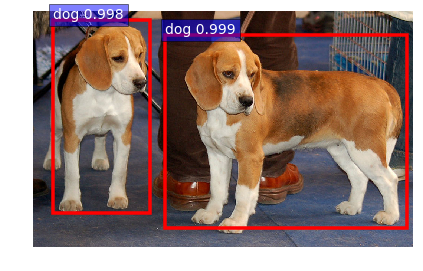

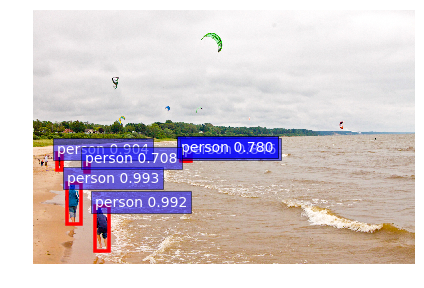

In [76]:
img_dir = "test_images/*.jpg"
NMS_THRESH = 1
demo(img_dir, NMS_THRESH)

In [53]:
outputs

[{'class': u'person',
  'height': 113.1381402015686,
  'score': 0.9778828,
  'width': 131.17408752441406,
  'x': 472.3576068878174,
  'y': 418.8618597984314},
 {'class': u'person',
  'height': 96.59533166885376,
  'score': 0.96885765,
  'width': 125.28810501098633,
  'x': 205.6455373764038,
  'y': 433.4532551765442},
 {'class': u'person',
  'height': 135.28249382972717,
  'score': 0.9643577,
  'width': 119.55151557922363,
  'x': 679.281759262085,
  'y': 396.15783047676086},
 {'class': u'person',
  'height': 176.9834065437317,
  'score': 0.95132405,
  'width': 129.10507917404175,
  'x': 2.0334720611572266,
  'y': 324.4216125011444},
 {'class': u'person',
  'height': 77.0434021949768,
  'score': 0.9393379,
  'width': 103.49404811859131,
  'x': 339.4568681716919,
  'y': 453.63433623313904},
 {'class': u'person',
  'height': 98.72086262702942,
  'score': 0.9288022,
  'width': 100.77027976512909,
  'x': 5.622640252113342,
  'y': 433.2791373729706},
 {'class': u'person',
  'height': 172.0314